## Example 6.5: Windy Gridworld 
Shown inset below is a standard gridworld, with start and goal states, but with one difference: there is a crosswind running upward through the middle of the grid. The actions are the standard four—up, down, right, and left—but in the middle region the resultant next states are shifted upward by a “wind,” the strength of which varies from column to column. The strength of the wind is given below each column, in number of cells shifted upward.
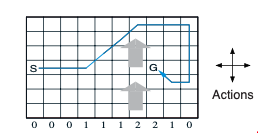

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

%matplotlib inline
from mpl_toolkits import mplot3d
from itertools import product 
from termcolor import colored
from matplotlib import colors

In [2]:
class GridworldEnv:
  def __init__(self, size, startpoint, endpoint, actions, wind, stochastic = False):
    self.m, self.n = size
    self.actions = actions
    self.stochastic = stochastic
    self.wind = wind
    self.endpoint = endpoint
    self.startpoint = startpoint

  def step(self, position, action):
    if action not in self.actions:
      raise Exception("The action (%s,%s) is not allowed!!" %action)

    reward = -1
    Done = False
    r, c = position
    a, b = action
    new_r, new_c = r-a-self.wind[c], c+b

    if new_c > self.n-1:
      new_c = self.n-1
    elif new_c < 0:
      new_c = 0 

    if self.stochastic and self.wind[c] > 0:
      noise = np.random.choice([-1, 0, 1])
      new_r = new_r - noise

    if new_r > self.m - 1:
      new_r = self.m - 1
    elif new_r < 0:
      new_r = 0   

    if (new_r, new_c) == self.endpoint:
      reward = 0
      Done = True
       
    return (new_r, new_c), reward, Done

In [3]:
Arrow = {}
Arrow[(0,0)] = '.'
Arrow[(0,-1)] = '\u2190' #Leftwards Arrow
Arrow[(1,0)] = '\u2191' #Upwards Arrow
Arrow[(0,1)] = '\u2192' #Rightwards Arrow
Arrow[(-1,0)] = '\u2193' #Downwards Arrow
Arrow[(1,-1)] = '\u2196' #North West Arrow
Arrow[(1,1)] = '\u2197' #North East Arrow
Arrow[(-1,1)] = '\u2198' #South East Arrow
Arrow[(-1,-1)] = '\u2199' #South West Arrow

In [4]:
class Gridworld:
  def __init__(self, Env, n_iters = 100, n_steps =1,
               gamma = 1, eps = .1, alpha = .1, Type =  'Sarsa'):
    self.Type = Type
    self.Env = Env
    self.actions = Env.actions
    self.behaiviar_policy = {}
    self.Q = {}
    for x in range(Env.m):
      for y in range(Env.n):
        if (x,y) != Env.endpoint:
          self.behaiviar_policy[(x,y)] = [1/len(Env.actions) for _ in Env.actions]
          self.Q[(x,y)] = {}
          for action in Env.actions:
            self.Q[(x,y)][action] = 0

    sum_episodes_length = 0
    t1 = t = time.time()
    self.episode_history = []
    
    st = 1
    for x in range(1, n_iters+1): 
      cnt = 0            
      state = Env.startpoint
      Done = False
      SARSAlist = []
      G = 0
      reward = 0
      while len(SARSAlist) < n_steps and not Done:
        action = self.apply_behaiviar_policy(state)
        next_state, reward, Done = Env.step(state, action)
        SARSAlist.append((state, action, reward))
        G += gamma**(cnt) * reward
        state = next_state
        cnt += 1
        sum_episodes_length += 1

      while  len(SARSAlist) > 0:                              
        s, a, r = SARSAlist.pop(0)
        if not Done:
          cnt += 1
          action = self.apply_behaiviar_policy(state)
          next_state, reward, Done = Env.step(state, action)
          SARSAlist.append((state, action, reward))
          if Type == 'Sarsa':
            temp = G + gamma**n_steps * self.Q[state][action]
          elif Type == 'Q-learning':
            temp = G + gamma**n_steps * max(self.Q[state].values())
          elif Type == 'Expected-Sarsa':
            temp = G + gamma**n_steps * self.expected_sarsa(state)
          else:
            raise Exception("Unknown Type!! Valid types are: Sarsa, Q-learning, and Expected-Sarsa.")
          state = next_state
          G = (G-r)/gamma + gamma**(n_steps-1) * reward
          sum_episodes_length += 1
        else:
          temp = G
          G = (G-r)/gamma
        self.Q[s][a] = self.Q[s][a] + alpha * (temp - self.Q[s][a])
        self.update_behaiviar_policy(eps, state = s)
      
      if x % 10 == 0:
        self.episode_history.append(sum_episodes_length/x)
                      
    print(colored('Ended in %s seconds', 'white', 'on_grey') %(time.time() - t))


  def expected_sarsa(self, state):
    P = self.behaiviar_policy[state]
    mu = 0
    for i, a in enumerate(self.actions):
      mu += P[i]*self.Q[state][a]
    return mu

  def apply_behaiviar_policy(self, state):
    probabilities = self.behaiviar_policy[state]
    index = np.random.choice(range(len(self.actions)), p = probabilities)
    next_action = self.actions[index]
    return next_action
        

  def update_behaiviar_policy(self, eps, state = None):
    if state is None:
      States = self.states
    else:
      States = [state]
    for s in States:
      Max = max(self.Q[s].values())
      index = np.random.choice([x for x in range(len(self.actions))
                                if self.Q[s][self.actions[x]] >= Max])
                    
      best_action = self.actions[index]
      for idx in range(len(self.actions)):
        if best_action == self.actions[idx]:
          self.behaiviar_policy[s][idx] = 1 - eps + eps/len(self.actions)
        else:
          self.behaiviar_policy[s][idx] = eps/len(self.actions) 

  def get_optimal_policy(self):
    for state in self.behaiviar_policy.keys():
      idx = np.argmax(self.behaiviar_policy[state])
      self.target_policy[state] = self.actions[idx]

  def bulid_trajectory(self, point):
    Done = False 
    tr = []
    state = point
    while not Done:
      action = self.actions[np.argmax(self.behaiviar_policy[state])]
      tr.append((state, action))
      state, _, Done = Env.step(state, action)
    return tr

  def plot_optimal_policy(self, figsize):
    plt.subplots(figsize = figsize)
    Matrix = np.zeros((self.Env.m, self.Env.n)).astype(int)
    Matrix[self.Env.startpoint] = 1
    Matrix[self.Env.endpoint] = 2
    trajectory = self.bulid_trajectory(self.Env.startpoint)
    action_trace = {}
    for i, point in enumerate(trajectory):
        action_trace[point[0]] = Arrow[point[1]]
        if point[0] != self.Env.startpoint:
          Matrix[point[0]] = -i-1
    show_annot_array = Matrix < 0
    show_annot_array[self.Env.startpoint] = True
    cmap = colors.ListedColormap(['black','green','blue','white','red'])
    bounds=[-100, -0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig = sns.heatmap(Matrix, cmap=cmap, annot=True, annot_kws={"size":18},
                      linewidth=0.05, linecolor ='black', xticklabels=False, 
                      yticklabels=False, norm = norm, cbar= False, square = True )
    fig.set_title("Optimal Policy: " + self.Type, fontsize=15)
    
    for text, position in zip(fig.texts, ((u,v) for u in range(self.Env.m) for v in range(self.Env.n))):
        if self.Env.startpoint == position:
          text.set_text(str(action_trace[position])+'\n Start')
        elif show_annot_array[position] == True:
          text.set_text(str(action_trace[position])+'\n '+ str(np.abs(Matrix[position])))
        elif self.Env.endpoint == position:
          text.set_text('Goal')
          show_annot_array[position] = True
        text.set_visible(show_annot_array[position])
    plt.show()

    plt.subplots(figsize = figsize)
    fig2 = sns.heatmap(np.array(Env.wind).reshape(1,-1), cmap=['yellow'], annot=True, annot_kws={"size":18},
                      linewidth=0.05, linecolor ='black', xticklabels=False, 
                      yticklabels=False, norm = None, cbar= False, square = True )
    for text, v in zip(fig2.texts, (v for v in range(self.Env.n))):
        text.set_text('\u2191' +'\n'+ str(self.Env.wind[v]) )
        text.set_visible(True)
    fig2.set_xlabel('Wind strength', fontsize=10)
    plt.show()
    plt.close()    

# Exercise 6.9: Windy Gridworld with King’s Moves
Resolve the windy gridworld assuming eight possible actions, including the diagonal moves, rather than the usual four. How much better can you do with the extra actions? Can you do even better by including a ninth action that causes no movement at all other than that caused by the wind?

### 1. With four regular movement!

Ended in 9.044421911239624 seconds


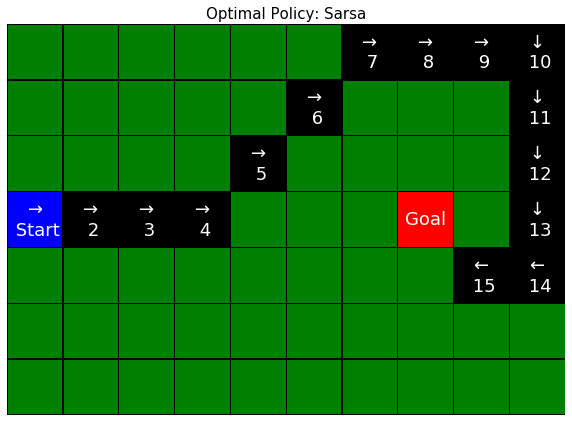

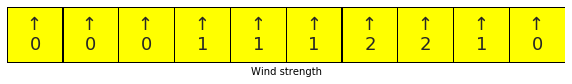

In [5]:
actions=[(0,1), (1,0), (0,-1), (-1,0)]
Env = GridworldEnv(size = (7,10), startpoint = (3,0), endpoint = (3,7), 
                 actions = actions, 
                 wind = [0,0,0,1,1,1,2,2,1,0], stochastic = False)
result = Gridworld(Env = Env, n_iters = 5000, n_steps = 1, Type = 'Sarsa')
result.plot_optimal_policy(figsize=(10,10))

### 2. With eight possible actions, including the diagonal moves

Ended in 5.4139931201934814 seconds


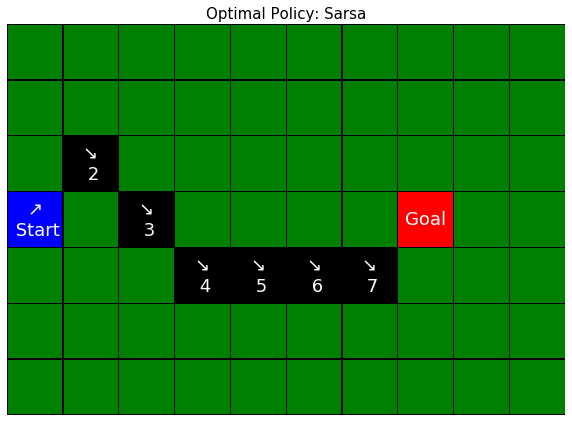

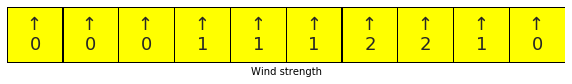

In [6]:
actions=[(0,1), (1,0), (0,-1), (-1,0), (1,1), (-1,1), (-1,-1), (1,-1) ]
Env = GridworldEnv(size = (7,10), startpoint = (3,0), endpoint = (3,7), 
                 actions = actions, 
                 wind = [0,0,0,1,1,1,2,2,1,0], stochastic = False)
result = Gridworld(Env = Env, n_iters = 5000, n_steps = 1, Type = 'Sarsa')
result.plot_optimal_policy(figsize=(10,10))

### 3. With all nine possible actions, including a ninth action that causes no movement!!

Ended in 7.795072078704834 seconds


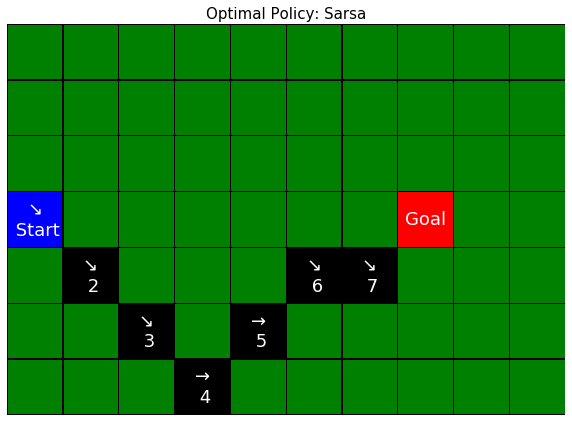

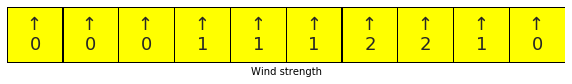

In [7]:
actions=[(0,1), (1,0), (0,-1), (-1,0), (1,1), (-1,1), (-1,-1), (1,-1), (0,0) ]
Env = GridworldEnv(size = (7,10), startpoint = (3,0), endpoint = (3,7), 
                 actions = actions, 
                 wind = [0,0,0,1,1,1,2,2,1,0], stochastic = False)
result = Gridworld(Env = Env, n_iters = 5000, n_steps = 1, Type = 'Sarsa')
result.plot_optimal_policy(figsize=(10,10))

# Exercise 6.10: Stochastic Wind (programming) 
Re-solve the windy gridworld task with King’s moves, assuming that the effect of the wind, if there is any, is stochastic, sometimes varying by $1$ from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous exercise, but also a third of the time you move one cell above that, and another third of the time you move one cell below that. For example, if you are one cell to the right of the goal and you move left, then one-third of the time you move one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal.

### 1. With four regular movement and Stochastic Wind

Ended in 17.101821899414062 seconds


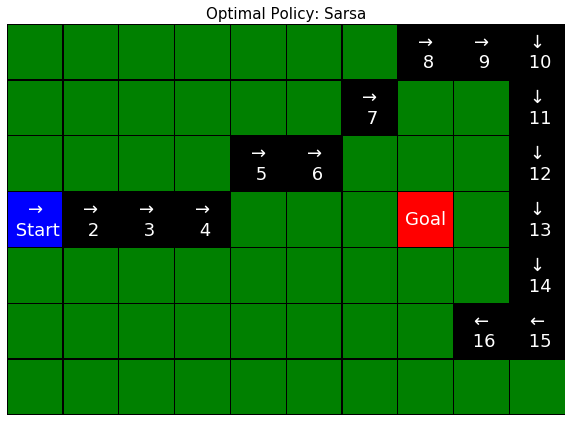

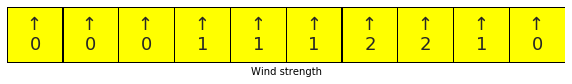

In [8]:
actions=[(0,1), (1,0), (0,-1), (-1,0)]
Env = GridworldEnv(size = (7,10), startpoint = (3,0), endpoint = (3,7), 
                 actions = actions, 
                 wind = [0,0,0,1,1,1,2,2,1,0], stochastic = True)
result = Gridworld(Env = Env, n_iters = 5000, n_steps = 1, Type = 'Sarsa')
result.plot_optimal_policy(figsize=(10,10))

### 2. With eight possible actions, including the diagonal moves

Ended in 15.636184215545654 seconds


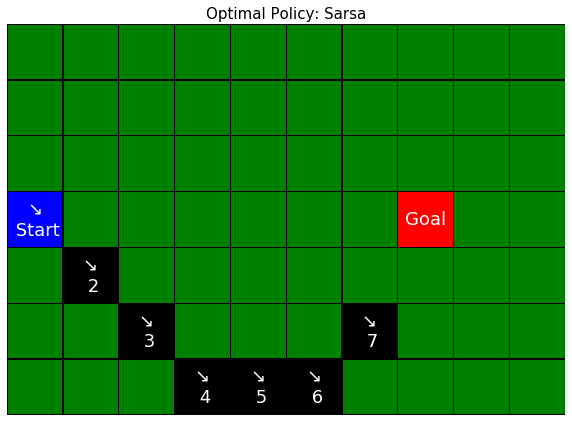

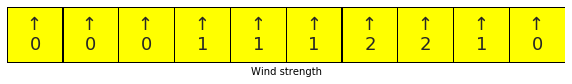

In [9]:
actions=[(0,1), (1,0), (0,-1), (-1,0), (1,1), (-1,1), (-1,-1), (1,-1) ]
Env = GridworldEnv(size = (7,10), startpoint = (3,0), endpoint = (3,7), 
                 actions = actions, 
                 wind = [0,0,0,1,1,1,2,2,1,0], stochastic = True)
result = Gridworld(Env = Env, n_iters = 5000, n_steps = 1, Type = 'Sarsa')
result.plot_optimal_policy(figsize=(10,10))

### 3. With all nine possible actions, including a ninth action that causes no movement!!

Ended in 16.669363975524902 seconds


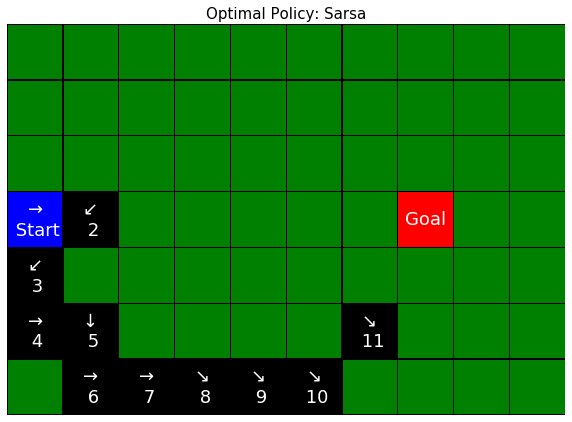

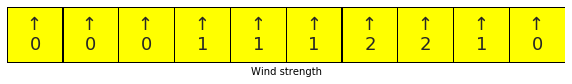

In [10]:
actions=[(0,1), (1,0), (0,-1), (-1,0), (1,1), (-1,1), (-1,-1), (1,-1), (0,0) ]
Env = GridworldEnv(size = (7,10), startpoint = (3,0), endpoint = (3,7), 
                 actions = actions, 
                 wind = [0,0,0,1,1,1,2,2,1,0], stochastic = True)
result = Gridworld(Env = Env, n_iters = 5000, n_steps = 1, Type = 'Sarsa')
result.plot_optimal_policy(figsize=(10,10))